## 19.3 PETS代码实践(Pendulum-v1)

导入相关库：

In [2]:
# 基本库
import numpy as np
from scipy.stats import truncnorm  # 用于生成和操作截断正态分布（Truncated Normal Distribution）
import itertools  # 生成迭代器和组合、排列等高效遍历操作
import collections

# 神经网络
import torch
import torch.nn.functional as F
import torch.nn as nn
# Gymnasium 是一个用于开发和测试强化学习算法的工具库，为 OpenAI Gym 的更新版本（2021迁移开发）
import gymnasium as gym

***候选动作序列的生成：交叉熵方法（CEM）：***

In [3]:
class CEM:  # 优化随机采样动作的分布的均值和方差
    def __init__(self, n_sequence, elite_ratio, fake_env, upper_bound, lower_bound):
        self.n_sequence = n_sequence  # 生成的动作序列数量
        self.elite_ratio = elite_ratio  # 精英策略的比例（选择最好的前elite_ratio部分）
        self.upper_bound = upper_bound
        self.lower_bound = lower_bound
        self.fake_env = fake_env  # 用来模拟环境的虚拟环境对象

    def optimize(self, state, init_mean, init_var):
        mean, var = init_mean, init_var  # 初始动作分布
        X = truncnorm(-2, 2, loc=np.zeros_like(mean), scale=np.ones_like(var))  # 创建n维（动作维度）截断正态分布对象
        state = np.tile(state, (self.n_sequence, 1))  # 扩展 n_sequence 个相同的状态，对应多个动作序列

        for _ in range(5):  # 重复进行多次优化
            lb_dist, ub_dist = mean - self.lower_bound, self.upper_bound - mean
            constrained_var = np.minimum(np.minimum(np.square(lb_dist / 2), np.square(ub_dist / 2)), var)  # 方差的约束
            # 生成动作序列(n_sequence，act_dim*plan_horizon)
            action_sequences = [X.rvs() for _ in range(self.n_sequence)] * np.sqrt(constrained_var) + mean
            # 计算每条动作序列的累积奖励
            returns = self.fake_env.propagate(state, action_sequences)[:, 0]
            # 选取累积奖励高的若干条动作序列（精英序列）
            elites = action_sequences[np.argsort(returns)][-int(self.elite_ratio * self.n_sequence):]
            new_mean = np.mean(elites, axis=0)
            new_var = np.var(elites, axis=0)
            # 指数加权平均平滑更新动作序列分布
            mean = 0.1 * mean + 0.9 * new_mean
            var = 0.1 * var + 0.9 * new_var

        return mean

In [4]:
# 模拟 CEM 中的参数
n_sequence = 2
action_dim = 3
mean = np.array([0.5])
var = np.array([0.1])

# 单条动作序列长度控制
mean = np.tile(mean,2)
print("内容:", mean)
print("形状:", np.array(mean).shape)

# 截断正态分布对象
X = truncnorm(-2, 2, loc=np.zeros_like(mean), scale=np.ones_like(var))

# 生成动作序列
action_sequences = [X.rvs() for _ in range(n_sequence)]
print("内容:", action_sequences)
print("形状:", np.array(action_sequences).shape)

actions = torch.as_tensor(action_sequences)
action = torch.unsqueeze(actions[:, 0], 1)
print("内容:", action)
print("形状:", action.shape)

内容: [0.5 0.5]
形状: (2,)
内容: [array([0.21312777, 0.16434273]), array([-0.1878664 , -0.17877162])]
形状: (2, 2)
内容: tensor([[ 0.2131],
        [-0.1879]], dtype=torch.float64)
形状: torch.Size([2, 1])


C:\Users\86191\AppData\Local\Temp\ipykernel_24680\4165825641.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  actions = torch.as_tensor(action_sequences)


In [5]:
env_name = 'Pendulum-v1'
env = gym.make(env_name)
state, info = env.reset()

print("内容:", state)
print("形状:", np.array(state).shape)
state = np.tile(state, (n_sequence, 1))
print("内容:", state)
print("形状:", np.array(state).shape)

内容: [ 0.73121476 -0.6821473  -0.25939333]
形状: (3,)
内容: [[ 0.73121476 -0.6821473  -0.25939333]
 [ 0.73121476 -0.6821473  -0.25939333]]
形状: (2, 3)


### 1.环境模型中每一层的构造

***激活函数定义：***

In [6]:
class Swish(nn.Module):
    """ Swish激活函数 """
    def __init__(self):
        super(Swish, self).__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)


![Swish_ReLU_Sigmoid三个激活函数的曲线对比图](Illustrations/Swish_ReLU_Sigmoid三个激活函数的曲线对比图.png)

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

***初始化网络层参数：***

In [8]:
def init_weights(m):  # m 为某个网络层
    """ 初始化模型权重 """
    def truncated_normal_init(t, mean=0.0, std=0.01):
        """ 截断正态分布 """
        torch.nn.init.normal_(t, mean=mean, std=std)  # 用均值为 mean、标准差为 std 的正态分布随机数填充张量t 
        while True:
            cond = (t < mean - 2 * std) | (t > mean + 2 * std)
            if not torch.sum(cond):  # 如果所有值都在范围内 (torch.sum(cond) == 0)，就退出循环
                break
            t = torch.where(
                cond,
                torch.nn.init.normal_(torch.ones(t.shape, device=device),mean=mean,std=std), 
                t)  # 如果有越界的值，就重新采样，并用 torch.where 把这些位置替换成新的采样值
        return t

    if type(m) == nn.Linear or isinstance(m, FCLayer):  # 若 m 是全连接层（nn.Linear）或 自定义层 FCLayer
        truncated_normal_init(m.weight, std=1 / (2 * np.sqrt(m._input_dim)))  # 权重 m.weight 用截断正态分布初始化
        m.bias.data.fill_(0.0)  # 偏置 m.bias 全部设为 0


> 标准差缩放技巧，保证方差不会太大：
$$\mathrm{std}=\frac{1}{2\sqrt{m-inputdim}}$$

***自定义的全连接层：***

In [9]:
class FCLayer(nn.Module):
    """ 自定义的全连接层 (FCLayer)，支持 ensemble（集成） """
    # ensemble_size: 集成的个数（即同时训练多少组独立的参数）
    # activation: 激活函数（如 ReLU、Swish）
    def __init__(self, input_dim, output_dim, ensemble_size, activation):
        super(FCLayer, self).__init__()
        self._input_dim, self._output_dim = input_dim, output_dim
        self.weight = nn.Parameter(torch.Tensor(ensemble_size, input_dim, output_dim).to(device))
        self._activation = activation
        self.bias = nn.Parameter(torch.Tensor(ensemble_size, output_dim).to(device))

    def forward(self, x):
        return self._activation(
            torch.add(torch.bmm(x, self.weight), self.bias[:, None, :]))  # 矩阵计算
            # X:(ensemble_size, batch_size, input_dim)
            # W:(ensemble_size, input_dim, output_dim)
            # 偏置bias扩展到 (ensemble_size, batch_size, output_dim)

### 2.集成环境模型设计

***softplus 函数：***
$$\mathrm{softplus}(x)=\log(1+e^x)$$
- **softplus** 常用于 **平滑 和 数值约束**
- 相比直接 clamp()，**softplus** **可导且更平滑**，不会破坏训练梯度

In [10]:
class EnsembleModel(nn.Module):
    """ 环境模型集成 """
    def __init__(self,
                 state_dim,
                 action_dim,
                 ensemble_size=5,  # 模型成员总数为ensemble_size，对应训练ensemble_size组权重
                 learning_rate=1e-3):
        super(EnsembleModel, self).__init__()
        self._output_dim = (state_dim + 1) * 2  # 预测奖励与状态增量 以及 对应方差
        # 方差上界和下界
        self._max_logvar = nn.Parameter((torch.ones(
            (1, self._output_dim // 2)).float() / 2).to(device),
                                        requires_grad=False)
        self._min_logvar = nn.Parameter((-torch.ones(
            (1, self._output_dim // 2)).float() * 10).to(device),
                                        requires_grad=False)
        # 集成模型中每个成员为5层神经网络
        self.layer1 = FCLayer(state_dim + action_dim, 200, ensemble_size, Swish())
        self.layer2 = FCLayer(200, 200, ensemble_size, Swish())
        self.layer3 = FCLayer(200, 200, ensemble_size, Swish())
        self.layer4 = FCLayer(200, 200, ensemble_size, Swish())
        self.layer5 = FCLayer(200, self._output_dim, ensemble_size, nn.Identity())  # nn.Identity()，原样返回输入
        self.apply(init_weights)  # 对所有 nn.Linear 和 FCLayer 层做权重初始化
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x, return_log_var=False):  # 选择是否返回对数方差
        # 前向传播
        ret = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        # 输出一分为二
        mean   = ret[:, :, :self._output_dim // 2]   # 前一半 -> 均值
        raw_lv = ret[:, :, self._output_dim // 2:]   # 后一半 -> 原始对数方差 logvar（未约束）
        # 使用softplus函数,将方差控制在最小值和最大值之间
        logvar = self._max_logvar - F.softplus(self._max_logvar - raw_lv)
        logvar = self._min_logvar + F.softplus(logvar - self._min_logvar)
        return mean, logvar if return_log_var else torch.exp(logvar)

    def loss(self, mean, logvar, labels, use_var_loss=True):  # 是否选择带方差的 loss
        inverse_var = torch.exp(-logvar)
        if use_var_loss:
            # 对应简化损失函数
            mse_loss = torch.mean(torch.mean(torch.pow(mean - labels, 2) * inverse_var,
                                             dim=-1),dim=-1)
            var_loss = torch.mean(torch.mean(logvar, dim=-1), dim=-1)
            total_loss = torch.sum(mse_loss) + torch.sum(var_loss)
        else:
            # 退化为普通的 MSE
            mse_loss = torch.mean(torch.pow(mean - labels, 2), dim=(1, 2))
            total_loss = torch.sum(mse_loss)
        return total_loss, mse_loss

    def train_my(self, loss):
        self.optimizer.zero_grad()
        # 惩罚 _max_logvar 太大；惩罚 _min_logvar 太小
        loss += 0.01 * torch.sum(self._max_logvar) - 0.01 * torch.sum(self._min_logvar)
        loss.backward()
        self.optimizer.step()

***预测模型的训练：***
- 独立的训练顺序
- Mini-batch 训练
- 验证集评估

In [11]:
class EnsembleDynamicsModel:
    def __init__(self, state_dim, action_dim, num_network=5):
        self._num_network = num_network
        self._state_dim, self._action_dim = state_dim, action_dim
        self.model = EnsembleModel(state_dim,
                                   action_dim,
                                   ensemble_size=num_network)
        self._epoch_since_last_update = 0  # 在 5 次没有获得表现提升时就结束训练
        # 记录每个网络的最佳 epoch 和对应验证集损失，用于早停和选择最优模型
        self._snapshots = {i: (None, 1e10) for i in range(self._num_network)}

    # 模型成员并行训练
    def train(self,
              inputs,
              labels,
              batch_size=64,
              holdout_ratio=0.1,
              max_iter=20):
        # 设置训练集与验证集，holdout_ratio 默认为 0.1，即 10% 数据用于验证
        permutation = np.random.permutation(inputs.shape[0])
        inputs, labels = inputs[permutation], labels[permutation]
        
        num_holdout = int(inputs.shape[0] * holdout_ratio)
        train_inputs, train_labels = inputs[num_holdout:], labels[num_holdout:]  # 训练集：90%
        holdout_inputs, holdout_labels = inputs[:num_holdout], labels[:num_holdout]  # 验证集：10%
        # 复制验证集数据，使每个网络都能独立计算损失
        holdout_inputs = torch.from_numpy(holdout_inputs).float().to(device)
        holdout_labels = torch.from_numpy(holdout_labels).float().to(device)
        holdout_inputs = holdout_inputs[None, :, :].repeat([self._num_network, 1, 1])
        holdout_labels = holdout_labels[None, :, :].repeat([self._num_network, 1, 1])

        # itertools.count() 会无限产生整数：0,1,2,… ；实际训练结束条件在循环内部通过 _save_best 和 epoch > max_iter 来控制
        for epoch in itertools.count():  # itertools.count() 会无限产生整数：0,1,2,…
            # 为每个模型成员生成独立的训练顺序（认知不确定性）
            train_index = np.vstack([
                np.random.permutation(train_inputs.shape[0])
                for _ in range(self._num_network)
            ])
            # Mini-batch 训练
            for batch_start_pos in range(0, train_inputs.shape[0], batch_size):  # 按 batch_size 分块，逐个 batch 进行训练
                batch_index = train_index[:, batch_start_pos:batch_start_pos +batch_size]
                train_input = torch.from_numpy(train_inputs[batch_index]).float().to(device)
                train_label = torch.from_numpy(train_labels[batch_index]).float().to(device)

                mean, logvar = self.model(train_input, return_log_var=True)
                loss, _ = self.model.loss(mean, logvar, train_label)
                self.model.train_my(loss)
                
            # 用验证集评估 Mini-batch训练后 模型的性能
            with torch.no_grad():  # 在其作用域内禁止梯度计算
                mean, logvar = self.model(holdout_inputs, return_log_var=True)
                _, holdout_losses = self.model.loss(mean,
                                                    logvar,
                                                    holdout_labels,
                                                    use_var_loss=False)
                holdout_losses = holdout_losses.cpu()  # GPU 张量不能直接用于大多数 Python 操作
                break_condition = self._save_best(epoch, holdout_losses)
                if break_condition or epoch > max_iter:  # 结束训练
                    break

    def _save_best(self, epoch, losses, threshold=0.1):
        updated = False  # 标记本轮是否有网络取得了显著改进
        for i in range(len(losses)):
            current = losses[i]
            _, best = self._snapshots[i]
            improvement = (best - current) / best
            if improvement > threshold:
                self._snapshots[i] = (epoch, current)
                updated = True
        self._epoch_since_last_update = 0 if updated else self._epoch_since_last_update + 1
        return self._epoch_since_last_update > 5

    def predict(self, inputs, batch_size=64):  # 一次最大按 batch_size 预测，避免一次性占用过多显存
        mean, var = [], []
        for i in range(0, inputs.shape[0], batch_size):
            input = torch.from_numpy(inputs[i:min(i + batch_size, inputs.shape[0])]).float().to(device)
            # 用训练好的模型预测
            cur_mean, cur_var = self.model(input[None, :, :].repeat([self._num_network, 1, 1]), return_log_var=False)
            mean.append(cur_mean.detach().cpu().numpy())
            var.append(cur_var.detach().cpu().numpy())
        return np.hstack(mean), np.hstack(var)  # (num_network, total_samples, mean)，(num_network, total_samples, var)

***定义模拟环境 FakeEnv，用训练好的 EnsembleDynamicsModel 来预测下一状态和奖励：***

In [12]:
class FakeEnv:
    def __init__(self, model):
        self.model = model

    def step(self, obs, act):
        inputs = np.concatenate((obs, act), axis=-1)
        ensemble_model_means, ensemble_model_vars = self.model.predict(inputs)  
        # (num_network, n_states, mean)
        ensemble_model_means[:, :, 1:] += obs.numpy()  # 当前状态+预测的状态增量，变为下一状态
        ensemble_model_stds = np.sqrt(ensemble_model_vars)
        # 得出每个模型成员的预测结果并使用高斯采样
        ensemble_samples = ensemble_model_means + np.random.normal(
            size=ensemble_model_means.shape) * ensemble_model_stds

        num_models, batch_size, _ = ensemble_model_means.shape
        # 为每一个状态的下一步预测使用随机的模型成员
        models_to_use = np.random.choice([i for i in range(self.model._num_network)], size=batch_size)
        batch_inds = np.arange(0, batch_size)
        samples = ensemble_samples[models_to_use, batch_inds]
        # batch_size中每个状态都随机采用了某个模型成员进行预测（相应的奖励以及下一个状态）
        rewards, next_obs = samples[:, :1], samples[:, 1:]
        return rewards, next_obs

    def propagate(self, obs, actions):
        with torch.no_grad():
            obs = np.copy(obs)  # (n_sequence, state_dim)
            total_reward = np.expand_dims(np.zeros(obs.shape[0]), axis=-1)
            obs, actions = torch.as_tensor(obs), torch.as_tensor(actions)
            for i in range(actions.shape[1]):  # 生成的候选动作序列的长度
                action = torch.unsqueeze(actions[:, i], 1)  # 取每个生成序列中的第i个动作，并增加一个新维度，对齐状态obs
                rewards, next_obs = self.step(obs, action)
                total_reward += rewards
                obs = torch.as_tensor(next_obs)
            return total_reward  # 返回每条生成序列的总价值

***定义经验回放池Replay Buffer：***

In [13]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def size(self):
        return len(self.buffer)

    def return_all_samples(self):
        all_transitions = list(self.buffer)
        state, action, reward, next_state, done = zip(*all_transitions)
        return np.array(state), action, reward, np.array(next_state), done

### 3. PETS 算法

In [14]:
class PETS:
    """ PETS算法(Pendulum-v1) """
    def __init__(self, env, replay_buffer, n_sequence, elite_ratio,
                 plan_horizon, num_episodes):
        # 真实环境
        self._env = env
        self._env_pool = replay_buffer
        obs_dim = env.observation_space.shape[0]
        self._action_dim = env.action_space.shape[0]
        self.upper_bound = env.action_space.high[0]
        self.lower_bound = env.action_space.low[0]
        # 环境模型
        self._model = EnsembleDynamicsModel(obs_dim, self._action_dim)
        self._fake_env = FakeEnv(self._model)
        self._cem = CEM(n_sequence, elite_ratio, self._fake_env, self.upper_bound, self.lower_bound)
        
        self.plan_horizon = plan_horizon
        self.num_episodes = num_episodes

    def train_model(self):
        env_samples = self._env_pool.return_all_samples()
        obs = env_samples[0]
        actions = np.array(env_samples[1])
        rewards = np.array(env_samples[2]).reshape(-1, 1)
        next_obs = env_samples[3]
        inputs = np.concatenate((obs, actions), axis=-1)
        labels = np.concatenate((rewards, next_obs - obs), axis=-1)
        self._model.train(inputs, labels)

    def mpc(self):
        mean = np.tile((self.upper_bound + self.lower_bound) / 2.0, self.plan_horizon)
        var = np.tile(np.square(self.upper_bound - self.lower_bound) / 16, self.plan_horizon)
        obs, info = self._env.reset()
        done, episode_return = False, 0
        truncated = False
        while not (done or truncated):
            actions = self._cem.optimize(obs, mean, var)  # 优化后的候选动作序列
            action = actions[:self._action_dim]  # 选取第一个动作
            next_obs, reward, done, truncated, _ = self._env.step(action)
            self._env_pool.add(obs, action, reward, next_obs, done)
            obs = next_obs
            episode_return += reward
            mean = np.concatenate([
                np.copy(actions)[self._action_dim:],
                np.zeros(self._action_dim)
            ])  # 用于多次优化
        return episode_return

    def explore(self):
        obs, info = self._env.reset()
        done, episode_return = False, 0
        truncated = False
        while not (done or truncated):
            action = self._env.action_space.sample()
            next_obs, reward, done, truncated, _ = self._env.step(action)
            self._env_pool.add(obs, action, reward, next_obs, done)
            obs = next_obs
            episode_return += reward
        return episode_return

    def train(self):
        return_list = []
        explore_return = self.explore()  # 先进行随机策略的探索来收集一条序列的数据
        print('episode: 1, 初始随机动作采样return: %d' % explore_return)
        return_list.append(explore_return)

        for i_episode in range(self.num_episodes - 1):
            self.train_model()  # 每次迭代先对环境模型进行训练
            episode_return = self.mpc()  # 然后在环境模型的指导下选择动作，并计算指导序列的回报
            return_list.append(episode_return)
            print('episode: %d, return: %d' % (i_episode + 2, episode_return))
        return return_list

### 4.训练与测试

In [15]:
n_sequence = 50
elite_ratio = 0.2
plan_horizon = 25
num_episodes = 10

buffer_size = 100000
replay_buffer = ReplayBuffer(buffer_size)
pets = PETS(env, replay_buffer, n_sequence, elite_ratio, plan_horizon, num_episodes)

return_list = pets.train()

episode: 1, 初始随机动作采样return: -1176
episode: 2, return: -888
episode: 3, return: -1427
episode: 4, return: -1046
episode: 5, return: -1245
episode: 6, return: -1050
episode: 7, return: -267
episode: 8, return: -124
episode: 9, return: -257
episode: 10, return: -381


### 5.效果绘图

In [16]:
import pandas as pd
episodes_list = list(range(len(return_list)))
# 创建 DataFrame
df1 = pd.DataFrame({'Episodes': episodes_list, 'Returns': return_list})
# 保存为 CSV 文件
df1.to_csv('PETS_Pendulum-v1_returns_data.csv', index=False)

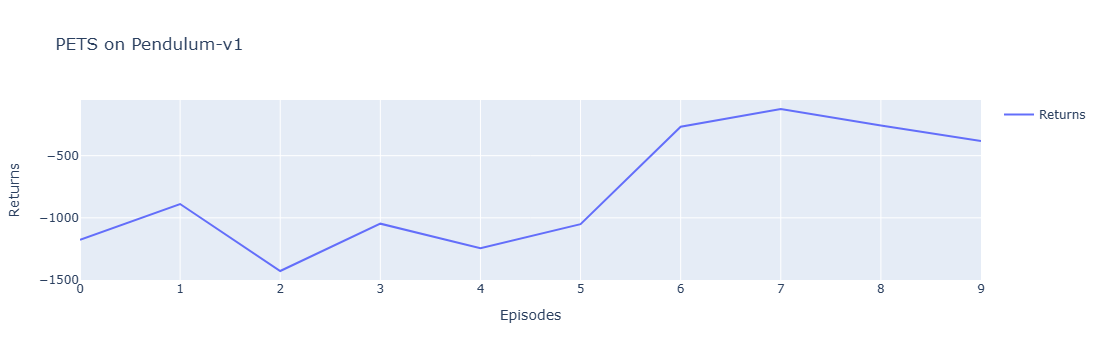

In [1]:
import plotly.graph_objects as go
import pandas as pd
df = pd.read_csv('PETS_Pendulum-v1_returns_data.csv')  # 从 CSV 文件中读取数据
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Episodes'], y=df['Returns'], mode='lines', name='Returns'))
fig.update_layout(
    title='PETS on Pendulum-v1',
    xaxis_title='Episodes',
    yaxis_title='Returns',
    showlegend=True
)
fig.show()

虽然每次选取动作都需要在环境模型上进行大量的模拟，运行速度慢
但 **PETS** 算法提高了样本效率，在与 **环境交互次数少得多** 的情况下就取得了与 **SAC** 算法的差不多的效果